# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [3]:
DATASET_PATH = '/Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/IndustryApplication/XRAY/CXR_data_UpGrad'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

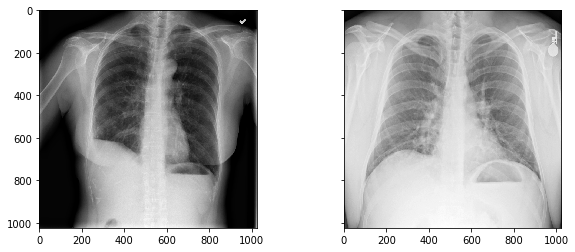

In [4]:
from skimage import io
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [5]:
effusion.shape

(1024, 1024)

In [6]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [7]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [8]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [9]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [10]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1)

W0904 11:37:23.873838 140735556289408 deprecation_wrapper.py:119] From /Users/snehabhatt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 11:37:23.919876 140735556289408 deprecation_wrapper.py:119] From /Users/snehabhatt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 11:37:23.930387 140735556289408 deprecation_wrapper.py:119] From /Users/snehabhatt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0904 11:37:23.978261 140735556289408 deprecation_wrapper.py:119] From /Users/snehabhatt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please 

Epoch 1/1


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1/1 [==============================] - 16s 16s/step - loss: 1.4416 - acc: 0.9000


In [11]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5)

Epoch 1/5


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1/1 [==============================] - 16s 16s/step - loss: 2.9545 - acc: 0.0625
Epoch 2/5
1/1 [==============================] - 10s 10s/step - loss: 2.0076 - acc: 0.0968
Epoch 3/5
1/1 [==============================] - 12s 12s/step - loss: 1.5836 - acc: 0.8065
Epoch 4/5
1/1 [==============================] - 10s 10s/step - loss: 1.4267 - acc: 0.9000
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 1.3237 - acc: 0.9333


In [12]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [13]:
from skimage import io
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 58s 12s/step - loss: 1.6209 - acc: 0.6517 - val_loss: 1.3062 - val_acc: 0.9062

Val AUC for epoch0: 0.8064516129032258
Epoch 2/5
4/5 [=======================>......] - ETA: 8s - loss: 1.3262 - acc: 0.8951 

/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 47s 9s/step - loss: 1.3043 - acc: 0.9035 - val_loss: 1.1637 - val_acc: 0.9688

Val AUC for epoch1: 0.25
Epoch 3/5
4/5 [=======================>......] - ETA: 9s - loss: 1.2927 - acc: 0.8947 

/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 49s 10s/step - loss: 1.3017 - acc: 0.8900 - val_loss: 1.2326 - val_acc: 0.9375

Val AUC for epoch2: 0.26666666666666666
Epoch 4/5
4/5 [=======================>......] - ETA: 8s - loss: 1.3011 - acc: 0.8881 

/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 47s 9s/step - loss: 1.2829 - acc: 0.8976 - val_loss: 1.2197 - val_acc: 0.9375

Val AUC for epoch3: 0.3392857142857143
Epoch 5/5
4/5 [=======================>......] - ETA: 8s - loss: 1.2896 - acc: 0.8944 

/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 47s 9s/step - loss: 1.2961 - acc: 0.8905 - val_loss: 1.3563 - val_acc: 0.8750

Val AUC for epoch4: 0.35714285714285715


In [14]:
from functools import partial
import keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [15]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=1)

Epoch 1/1


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1/1 [==============================] - 14s 14s/step - loss: 2.0192 - acc: 0.8710


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [16]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [17]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = '/Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 134s 10s/step - loss: 2.2977 - acc: 0.6039 - val_loss: 2.2503 - val_acc: 0.4479

Val AUC for epoch0: 0.6743295019157087

Epoch 00001: val_auc improved from -inf to 0.67433, saving model to /Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5
Epoch 2/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 119s 9s/step - loss: 2.1605 - acc: 0.6166 - val_loss: 2.1290 - val_acc: 0.5625

Val AUC for epoch1: 0.6434659090909091

Epoch 00002: val_auc did not improve from 0.67433
Epoch 3/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 124s 10s/step - loss: 2.1264 - acc: 0.6500 - val_loss: 2.0800 - val_acc: 0.6250

Val AUC for epoch2: 0.6983957219251337

Epoch 00003: val_auc improved from 0.67433 to 0.69840, saving model to /Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5
Epoch 4/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 510s 39s/step - loss: 2.0876 - acc: 0.5866 - val_loss: 2.2553 - val_acc: 0.6771

Val AUC for epoch3: 0.7088068181818181

Epoch 00004: val_auc improved from 0.69840 to 0.70881, saving model to /Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5
Epoch 5/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 143s 11s/step - loss: 2.0786 - acc: 0.6202 - val_loss: 2.0511 - val_acc: 0.6458

Val AUC for epoch4: 0.6780748663101603

Epoch 00005: val_auc did not improve from 0.70881
Epoch 6/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 140s 11s/step - loss: 2.0016 - acc: 0.6295 - val_loss: 2.2644 - val_acc: 0.6771

Val AUC for epoch5: 0.6581395348837209

Epoch 00006: val_auc did not improve from 0.70881
Epoch 7/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 134s 10s/step - loss: 2.0167 - acc: 0.6502 - val_loss: 2.2148 - val_acc: 0.6354

Val AUC for epoch6: 0.7330779054916985

Epoch 00007: val_auc improved from 0.70881 to 0.73308, saving model to /Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5
Epoch 8/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 158s 12s/step - loss: 2.0382 - acc: 0.6491 - val_loss: 2.0782 - val_acc: 0.6667

Val AUC for epoch7: 0.6743295019157088

Epoch 00008: val_auc did not improve from 0.73308
Epoch 9/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 134s 10s/step - loss: 2.0547 - acc: 0.6733 - val_loss: 2.1287 - val_acc: 0.6771

Val AUC for epoch8: 0.6232439335887612

Epoch 00009: val_auc did not improve from 0.73308
Epoch 10/10


/Users/snehabhatt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


13/13 [==============================] - 131s 10s/step - loss: 2.0605 - acc: 0.6538 - val_loss: 2.1788 - val_acc: 0.6354

Val AUC for epoch9: 0.7343550446998723

Epoch 00010: val_auc improved from 0.73308 to 0.73436, saving model to /Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5


## 5. Making a Prediction

In [35]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('/Users/snehabhatt/Desktop/Datascience-Python/DeepLearning/X-RayImages/models/best_model.hdf5')

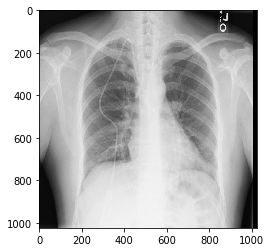

In [54]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-18])
plt.imshow(effusion,cmap='gray')

In [55]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])   #probablit of normal class .595 and effusion .404

array([[0.54694664, 0.45305333]], dtype=float32)